## 🌐 **Google Drive Connection**

In [ ]:
# 1️⃣ Import delle librerie principali
import matplotlib.pyplot as plt
import pandas as pd
import logging
import random
import numpy as np
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import os

# 2️⃣ Definisci la directory principale nel workspace di Colab
current_dir = '/content/Arialeto'

# 3️⃣ Crea la directory se non esiste
os.makedirs(current_dir, exist_ok=True)

# 4️⃣ Spostati nella directory del progetto
os.chdir(current_dir)
print(f"Working directory set to: {os.getcwd()}")

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1-GldjmW2UkrRzoKRsp0d_0BiDCphSh44/Arialeto2


## ⚙️ **Libraries Import**

In [ ]:
pip install pytorch-ranger

In [ ]:
# Set seed for reproducibility
SEED = 5415

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

import cv2

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from pytorch_ranger import Ranger

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading** QUI CAMBI IL PATH DEI DATI

In [ ]:
dataset_path = 'clean_patches/'

In [ ]:
def load_images_from_folder(folder):
    """
    Load and preprocess images from a specified folder.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        tuple: (np.ndarray, list) - Array of preprocessed images with shape (N, H, W, C) and a list of corresponding filenames.
    """
    images = []
    filenames = []

    # Get all image filenames first and sort them to ensure consistent order
    all_filenames = sorted([f for f in os.listdir(folder) if not f.startswith('mask') and not f.startswith('.')])

    for filename in all_filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[...,::-1]

        if img is not None:
            images.append(img)
            filenames.append(filename) # Store filename as well

    return np.array(images), filenames

In [ ]:
dataset, dataset_filenames = load_images_from_folder(dataset_path)

print(f"Loaded {len(dataset)} images")

Loaded 3907 images


##CSV IMAGE MAPPING LABEL

In [ ]:
df_labels = pd.read_csv("train_labels.csv")
df_labels.head()

,sample_index,label
0,img_0000.png,Triple negative
1,img_0001.png,Luminal B
2,img_0002.png,Luminal B
3,img_0003.png,Luminal B
4,img_0004.png,Luminal B


In [ ]:
# Get unique labels and store them in unique_labels variable
unique_labels = df_labels['label'].unique()
print(f"Unique labels: {unique_labels}")
class_to_id = {c: i for i, c in enumerate(unique_labels)}
print(f"Label mapping: {class_to_id}")

Unique labels: ['Triple negative' 'Luminal B' 'HER2(+)' 'Luminal A']
Label mapping: {'Triple negative': 0, 'Luminal B': 1, 'HER2(+)': 2, 'Luminal A': 3}


In [ ]:
patch_labels_data = []

for patch_filename in dataset_filenames:
    # Extract the base image name (e.g., 'img_0000.png' from 'img_0000_patch_0.png')
    base_image_name = patch_filename.split('_patch_')[0] + '.png'

    # Find the corresponding label in df_labels
    label_row = df_labels[df_labels['sample_index'] == base_image_name]

    if not label_row.empty:
        corresponding_label = label_row['label'].iloc[0]
        patch_labels_data.append({'sample_index': patch_filename, 'label': corresponding_label})

# Convert the list of dictionaries to a pandas DataFrame
df_labels_patch = pd.DataFrame(patch_labels_data)

# Print the head of the new DataFrame to verify
print(df_labels_patch.head())

             sample_index            label
0  img_0000_patch_000.png  Triple negative
1  img_0002_patch_000.png        Luminal B
2  img_0002_patch_001.png        Luminal B
3  img_0002_patch_002.png        Luminal B
4  img_0002_patch_003.png        Luminal B


## 🔎 **Exploration and Data Analysis**

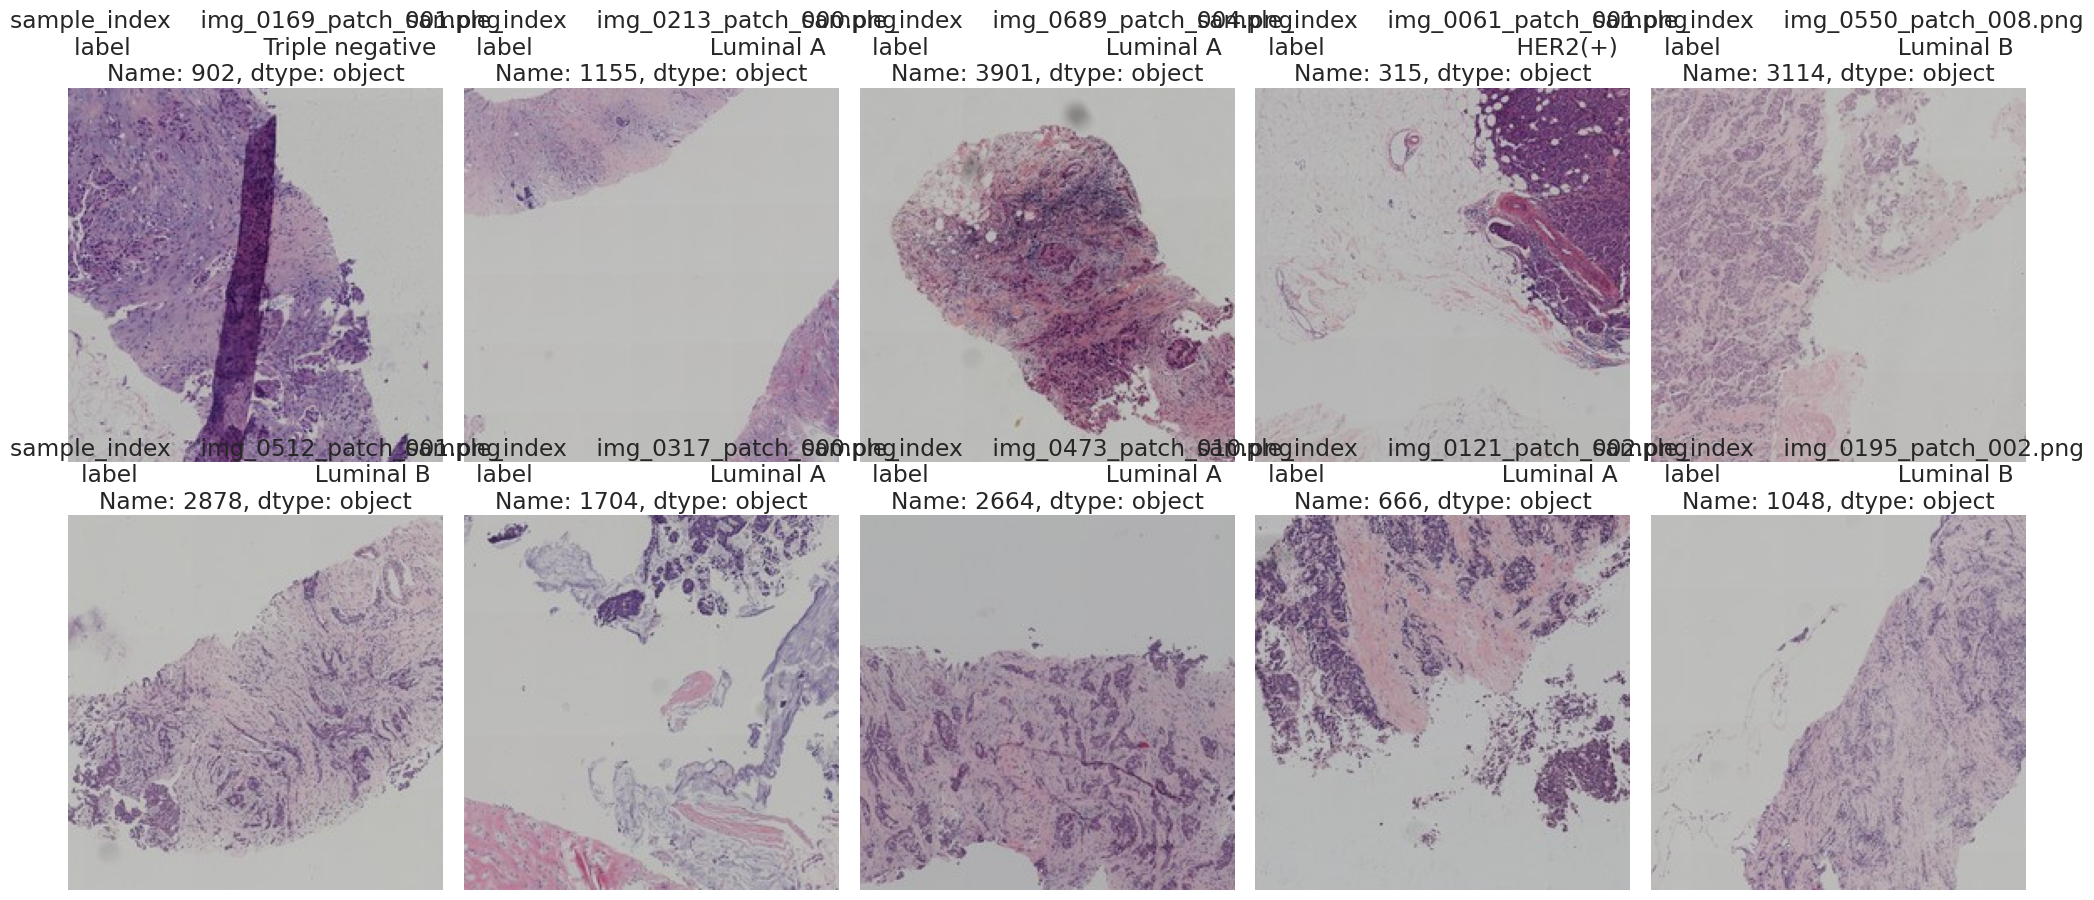

In [ ]:
# Number of images to display
num_img = 10
# Select random indices from the training set
random_indices = random.sample(range(len(dataset)), num_img)

# Create subplot layout for images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]

    # Display the image at the selected index (convert CHW to HWC)
    img = dataset[idx]
    ax.imshow(img)

    # Add class name as title
    class_name = df_labels_patch.iloc[idx]
    class_name = class_name.replace('_', ' ')
    ax.set_title(class_name, pad=5)

    # Remove axis lines for clearer display
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

##PLOT CLASS DISTRIBUTION

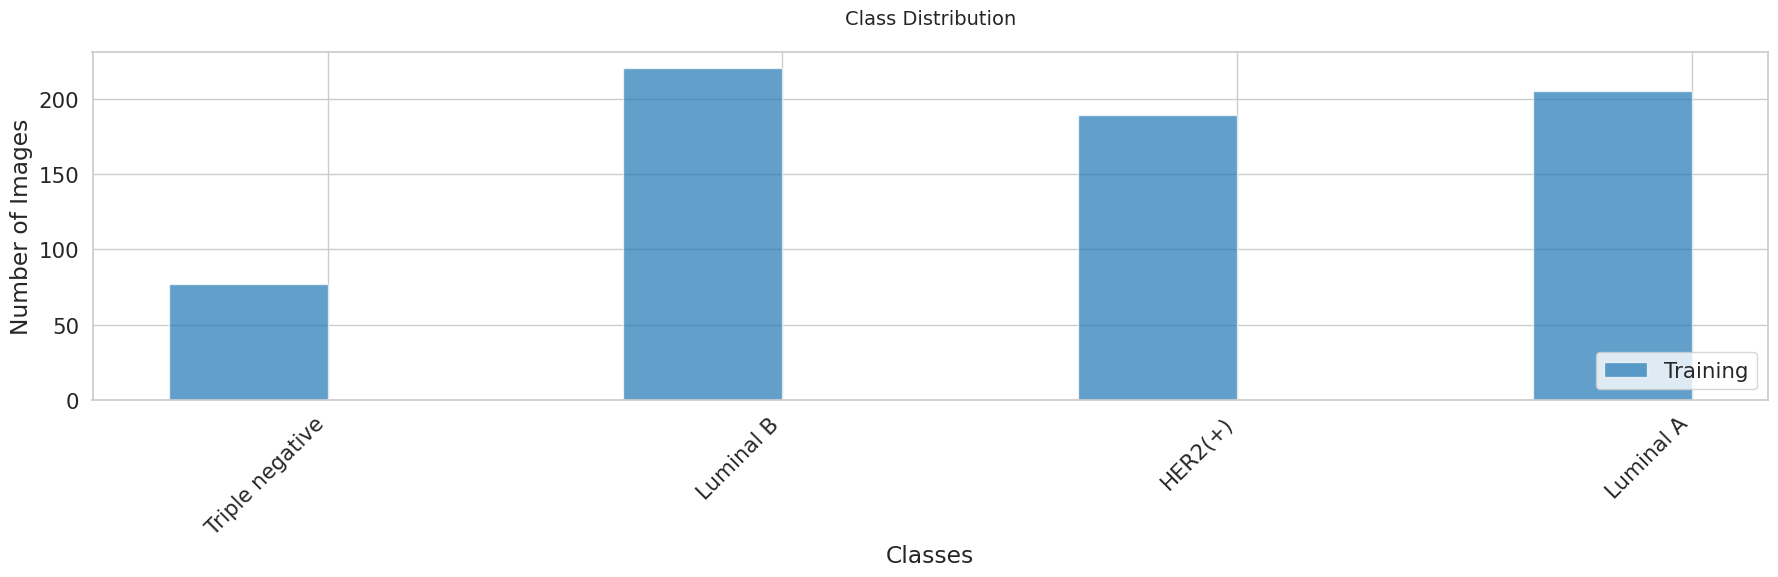

In [ ]:
def plot_class_distribution(y_train, class_names):
    """Plot class distribution for training and test sets."""
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Calculate class distributions for training and test sets
    train_dist = np.bincount(y_train)
    #test_dist = np.bincount(y_test)

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x - width / 2, train_dist, width, label='Training', color='#1f77b4', alpha=0.7)
    #plt.bar(x + width / 2, test_dist, width, label='Test', color='#ff7f0e', alpha=0.7)

    # Customize plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Add legend for training and test distributions
    plt.legend(loc='lower right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()

# 3) converti le label testuali in ID interi
y_train = df_labels["label"].map(class_to_id).to_numpy()   # array 1D di int

# 4) ora puoi usare la tua funzione
plot_class_distribution(y_train, class_to_id.keys())

## 🔄 **Data Preprocessing**

In [ ]:
y_train_val_df = df_labels_patch.copy()
y_train_val = y_train_val_df['label']

# Convert string labels to integer IDs using the predefined mapping
y_train_val = y_train_val.map(class_to_id)

print("First 5 elements of y_train_val:")
print(y_train_val.head())

First 5 elements of y_train_val:
0    0
1    1
2    1
3    1
4    1
Name: label, dtype: int64


In [ ]:
df_labels_patch['original_image_id'] = df_labels_patch['sample_index'].apply(lambda x: x.split('_patch_')[0] + '.png')

# Create a new DataFrame containing unique original image IDs and their labels
original_images_df = df_labels_patch[['original_image_id', 'label']].drop_duplicates().reset_index(drop=True)

# Verify the mapping by merging with df_labels to ensure consistency
# This step ensures that the 'label' associated with 'original_image_id' in original_images_df
# is consistent with the 'label' in the original df_labels for that 'sample_index'.
original_images_df = pd.merge(original_images_df, df_labels[['sample_index', 'label']],
                                  left_on='original_image_id', right_on='sample_index', how='left', suffixes=('_patch', '_original'))

# Keep only the original label if there's a conflict or simply verify
# Assuming the labels in df_labels are the ground truth for original images
original_images_df['label'] = original_images_df['label_original']
original_images_df = original_images_df[['original_image_id', 'label']]

print("First 5 rows of df_labels_patch with original_image_id:")
print(df_labels_patch.head())
print("\nFirst 5 rows of original_images_df:")
print(original_images_df.head())
print(f"\nTotal unique original images: {len(original_images_df)}")


First 5 rows of df_labels_patch with original_image_id:
             sample_index            label original_image_id
0  img_0000_patch_000.png  Triple negative      img_0000.png
1  img_0002_patch_000.png        Luminal B      img_0002.png
2  img_0002_patch_001.png        Luminal B      img_0002.png
3  img_0002_patch_002.png        Luminal B      img_0002.png
4  img_0002_patch_003.png        Luminal B      img_0002.png

First 5 rows of original_images_df:
  original_image_id            label
0      img_0000.png  Triple negative
1      img_0002.png        Luminal B
2      img_0003.png        Luminal B
3      img_0004.png        Luminal B
4      img_0006.png        Luminal A

Total unique original images: 578


In [ ]:
original_images_df['label_id'] = original_images_df['label'].map(class_to_id)

# Split original image IDs into training and validation sets, stratified by label
train_original_image_ids, val_original_image_ids = train_test_split(
    original_images_df['original_image_id'],
    test_size=0.2,
    random_state=SEED,
    stratify=original_images_df['label_id']
)

print(f"Number of original images in training set: {len(train_original_image_ids)}")
print(f"Number of original images in validation set: {len(val_original_image_ids)}")
print("First 5 training original image IDs:")
print(train_original_image_ids.head())
print("\nFirst 5 validation original image IDs:")
print(val_original_image_ids.head())

Number of original images in training set: 462
Number of original images in validation set: 116
First 5 training original image IDs:
236    img_0281.png
266    img_0314.png
561    img_0672.png
560    img_0671.png
476    img_0562.png
Name: original_image_id, dtype: object

First 5 validation original image IDs:
256    img_0303.png
81     img_0101.png
54     img_0069.png
484    img_0573.png
20     img_0029.png
Name: original_image_id, dtype: object


In [ ]:
train_patches_df = df_labels_patch[df_labels_patch['original_image_id'].isin(train_original_image_ids)]
val_patches_df = df_labels_patch[df_labels_patch['original_image_id'].isin(val_original_image_ids)]

# Get the original indices of these patches from the 'dataset_filenames' list
train_patch_indices = [dataset_filenames.index(f) for f in train_patches_df['sample_index']]
val_patch_indices = [dataset_filenames.index(f) for f in val_patches_df['sample_index']]

# Extract the image data and labels using these indices
X_train_new = dataset[train_patch_indices]
y_train_new = train_patches_df['label'].map(class_to_id).to_numpy()

X_val_new = dataset[val_patch_indices]
y_val_new = val_patches_df['label'].map(class_to_id).to_numpy()

print("Shapes after original image-level stratified split:")
print(f"X_train_new shape: {X_train_new.shape}")
print(f"y_train_new shape: {y_train_new.shape}")
print(f"X_val_new shape: {X_val_new.shape}")
print(f"y_val_new shape: {y_val_new.shape}")

Shapes after original image-level stratified split:
X_train_new shape: (3179, 224, 224, 3)
y_train_new shape: (3179,)
X_val_new shape: (728, 224, 224, 3)
y_val_new shape: (728,)


In [ ]:
# Define the input shape based on the training data (Pythorch want #channel, size)
input_shape = (X_train_new.shape[3], X_train_new.shape[1], X_train_new.shape[2])

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

##CHANGE HERE TO NORMALIZE

In [ ]:
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# converto da (N, H, W, C) → (N, C, H, W)
X_train_tensor = torch.from_numpy(X_train_new).permute(0, 3, 1, 2)  # float32 se possibile
X_val_tensor   = torch.from_numpy(X_val_new).permute(0, 3, 1, 2)

# se necessario: portale in float32 e in [0,1]
X_train_tensor = X_train_tensor.float()
X_val_tensor   = X_val_tensor.float()

# applico normalizzazione (broadcast su batch)
X_train_norm = normalize(X_train_tensor)
X_val_norm   = normalize(X_val_tensor)

# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(X_train_norm, torch.from_numpy(y_train_new).squeeze())
val_ds   = TensorDataset(X_val_norm, torch.from_numpy(y_val_new).squeeze())

Class Distribution for Training Set:


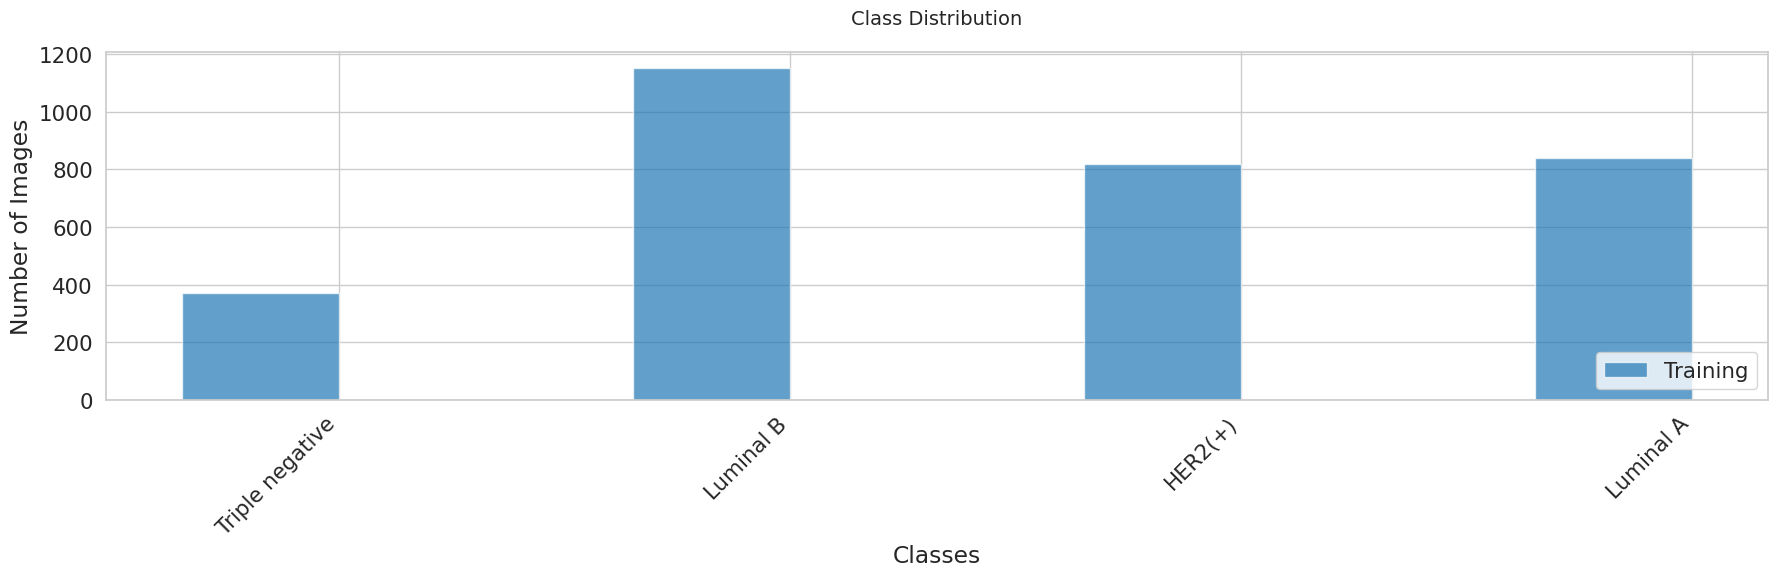


Class Distribution for Validation Set:


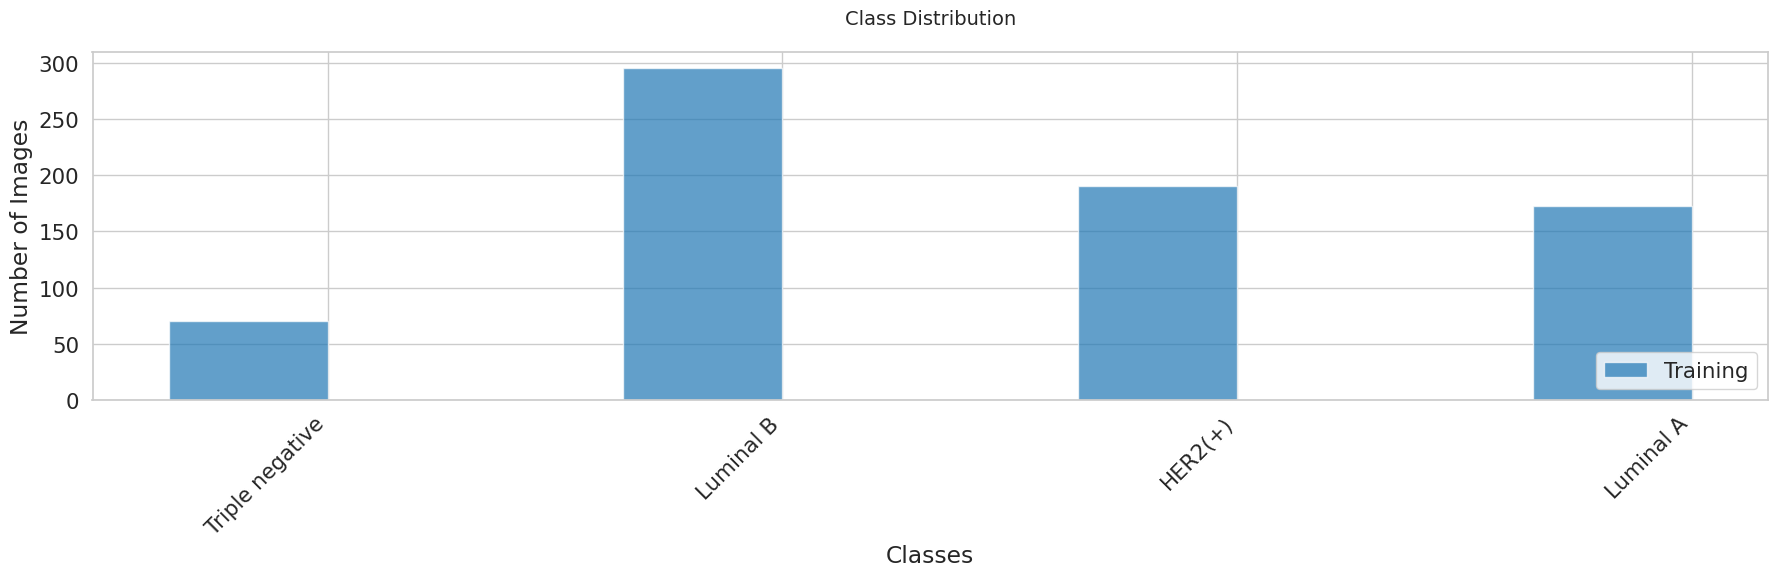

In [ ]:
# Plot class distribution for the training set
print("Class Distribution for Training Set:")
plot_class_distribution(y_train_new, class_to_id.keys())


# Plot class distribution for the validation set
print("\nClass Distribution for Validation Set:")
plot_class_distribution(y_val_new, class_to_id.keys())

In [ ]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 128

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


## 🧮 **Network Parameters, CAMBIARE IL NETNAME e NET TYPE**

In [ ]:
NET_TYPE = "ConvNextSmall"
NET_NAME = "ConvNextSmall(224,168,0.025,50)"

# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0.3         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# CLASS WEIGTHS
from sklearn.utils.class_weight import compute_class_weight

# ordered_classes is still valid as it defines the mapping
ordered_classes = np.array(sorted(class_to_id.values()))

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=ordered_classes,
    y=y_train_new
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights_tensor = torch.sqrt(class_weights_tensor)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Print the defined parameters
print("Class weights:", class_weights_tensor)
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Class weights: tensor([1.4617, 0.8313, 0.9857, 0.9733], device='cuda:0')
Epochs: 1000
Batch Size: 128
Learning Rare: 0.001
Dropout Rate: 0.3
L1 Penalty: 0
L2 Penalty: 0


## 🧠 **Training Functons**

In [ ]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", scheduler = None):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        if verbose > 0:
          if epoch % verbose == 0 or epoch == 1:
              current_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
              print(f"Epoch {epoch:3d}/{epochs} | LR: {current_lr:.6f} | "
                      f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                      f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)
            wip_folder = "models"

            # Create the folder if it doesn't exist
            os.makedirs(wip_folder, exist_ok=True)
            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## 🛠️ **Transfer Learning**

In [ ]:
import torchvision

class ConvNextSmallTransferLearning(nn.Module):
    def __init__(self, num_classes, dropout_rate, device, freeze_backbone=True):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.device = device
        self.freeze_backbone = freeze_backbone

        # Change the model initialization to load ImageNet pre-trained weights for ConvNeXt Small
        self.model = torchvision.models.convnext_small(weights=torchvision.models.ConvNeXt_Small_Weights.IMAGENET1K_V1)

        # If freeze_backbone is True, freeze all parameters excluding the final FC layer
        if self.freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False

        # Replace the model's final classifier layer (self.model.classifier)
        # ConvNeXt Small's classifier has a structure with a final Linear layer
        # The last layer in ConvNeXt Small's default classifier is a Linear layer after an AvgPool and Norm layer.
        # The in_features for this last Linear layer is 768.
        self.model.classifier = nn.Sequential(
          nn.Flatten(1),
          nn.LayerNorm(768, eps=1e-6),
          nn.Linear(768, 32),
          nn.ReLU(),
          nn.Dropout(self.dropout_rate),
          nn.Linear(32, self.num_classes)
      )

        # Move the entire model to the specified device
        self.model = self.model.to(self.device)

    def forward(self, x):
        return self.model(x)


print("ConvNextSmallTransferLearning class defined successfully.")

ConvNextSmallTransferLearning class defined successfully.


In [ ]:
# Create transfer learning model
tl_model = ConvNextSmallTransferLearning(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    device=device,
    freeze_backbone=True
).to(device)

In [ ]:
# Setup training
experiment_name = f"tl_{NET_NAME}_patches_{DROPOUT_RATE}drop_{L1_LAMBDA}L1_{L2_LAMBDA}L2_v2"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

WEIGHT_DECAY = 1e-4

#RANGER OPTMIZER
optimizer = Ranger(
    tl_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.95, 0.999)  # default tipici di Ranger
)

#scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=200,
                                                       eta_min=1e-6 )

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [ ]:
%%time
# Train with transfer learning
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_loader,
    val_loader=val_loader,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler = scheduler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_f1 = round(max(tl_history['val_f1']) * 100, 2)
print(f'Final validation F1 score: {final_val_f1}%')

Training 1000 epochs...
Epoch   1/1000 | LR: 0.001000 | Train: Loss=1.4069, F1 Score=0.2537 | Val: Loss=1.3779, F1 Score=0.2932
Epoch   5/1000 | LR: 0.000998 | Train: Loss=1.3394, F1 Score=0.3506 | Val: Loss=1.3371, F1 Score=0.3315
Epoch  10/1000 | LR: 0.000994 | Train: Loss=1.2786, F1 Score=0.4046 | Val: Loss=1.3336, F1 Score=0.3474
Epoch  15/1000 | LR: 0.000986 | Train: Loss=1.2392, F1 Score=0.4440 | Val: Loss=1.3494, F1 Score=0.3326
Epoch  20/1000 | LR: 0.000976 | Train: Loss=1.2057, F1 Score=0.4636 | Val: Loss=1.3727, F1 Score=0.3362
Epoch  25/1000 | LR: 0.000962 | Train: Loss=1.1730, F1 Score=0.4871 | Val: Loss=1.3823, F1 Score=0.3346
Epoch  30/1000 | LR: 0.000946 | Train: Loss=1.1424, F1 Score=0.5126 | Val: Loss=1.3973, F1 Score=0.3379
Epoch  35/1000 | LR: 0.000926 | Train: Loss=1.1163, F1 Score=0.5116 | Val: Loss=1.4256, F1 Score=0.3251
Epoch  40/1000 | LR: 0.000905 | Train: Loss=1.0869, F1 Score=0.5394 | Val: Loss=1.4536, F1 Score=0.3146
Epoch  45/1000 | LR: 0.000880 | Train: L

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation F1 Score on the second axis
ax2.plot(tl_history['train_f1'], label='Training F1 Score', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(tl_history['val_f1'], label='Validation F1 Score', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    tl_model.eval() # Set model to evaluation mode
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = tl_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## SAVE MODEL

In [ ]:
from datetime import datetime
model=tl_model
# Directory dove salvare
save_dir = 'saved_models/'
os.makedirs(save_dir, exist_ok=True)

# Esempio dati
model_id = experiment_name

# Salva il modello
model_path = os.path.join(save_dir, f'model_{model_id}_f1_{final_val_f1:.2f}.pth')
torch.save(model.state_dict(), model_path)

# Aggiorna CSV delle metriche
metrics_file = os.path.join(save_dir, f'{NET_TYPE}metrics.csv')
if os.path.exists(metrics_file):
    df_metrics = pd.read_csv(metrics_file)
else:
    df_metrics = pd.DataFrame(columns=['model_id','val_acc','val_prec','val_rec','val_f1', 'timestamp', 'path'])

df_metrics = pd.concat([df_metrics, pd.DataFrame([{
    'model_id': model_id,
    'val_f1' : final_val_f1,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'path': model_path
}])], ignore_index=True)

df_metrics.to_csv(metrics_file, index=False)

if os.path.exists(model_path):
    print(f"✅ Modello salvato correttamente in: {model_path}")
else:
    print("❌ Errore: il modello non è stato salvato")


✅ Modello salvato correttamente in: saved_models/model_tl_ConvNextSmall(224,168,0.025,50)_patches_0drop_0L1_0L2_f1_38.25.pth


## 🧮 **Network Parameters**

In [ ]:
# Number of training epochs
FT_LEARNING_RATE = 1e-5  # Lower learning rate for fine-tuning
EPOCHS = 1000
PATIENCE = 20

# Regularisation
FT_L1_LAMBDA = 0            # L1 penalty
FT_L2_LAMBDA = 0            # L2 penalty

# Unfreeze the last N layers of the backbone
N_LAYERS_TO_UNFREEZE = 1

## 🛠️ **Fine-Tuning**

In [ ]:
# Load the transfer learning model (instantiate it with freeze_backbone=False so its weights are initially trainable)
ft_model = ConvNextSmallTransferLearning(num_classes, DROPOUT_RATE, device=device, freeze_backbone=False).to(device)
# Load the previously saved weights from the transfer learning phase
# The experiment_name here refers to the previous tl_model save name
ft_model.load_state_dict(torch.load(f"models/tl_{NET_NAME}_patches_{DROPOUT_RATE}drop_{L1_LAMBDA}L1_{L2_LAMBDA}L2_model.pt"))


# First, freeze ALL parameters of the ConvNeXt Small base model (ft_model.model.features)
for param in ft_model.model.features.parameters():
    param.requires_grad = False

# The custom classification head (ft_model.model.classifier) is created in ConvNextSmallTransferLearning.__init__
# and its parameters should always be trainable for fine-tuning.
for param in ft_model.model.classifier.parameters():
    param.requires_grad = True

# Unfreeze last N stages of the ConvNeXt Small backbone (model.features)
# ConvNeXt Small's features are organized into stages: stage0, stage1, stage2, stage3.
all_stages = [name for name, module in ft_model.model.features.named_children() if 'stage' in name]
all_stages.sort(key=lambda x: int(x.replace('stage', '')), reverse=True) # Ensures order like ['stage3', 'stage2', 'stage1', 'stage0']

# Unfreeze the specified number of stages from the end
stages_to_unfreeze_names = all_stages[:N_LAYERS_TO_UNFREEZE]

print(f"Unfreezing stages: {stages_to_unfreeze_names}")

for stage_name in stages_to_unfreeze_names:
    stage = getattr(ft_model.model.features, stage_name)
    for param in stage.parameters():
        param.requires_grad = True

# Count trainable parameters
total_params = sum(p.numel() for p in ft_model.parameters())
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

# Display which layers are trainable
print("\nTrainable layers:")
for name, param in ft_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.numel():,} parameters")

Unfreezing layers: ['layer4', 'layer3']
Total parameters: 23,770,820
Trainable parameters: 22,325,892
Frozen parameters: 1,444,928

Trainable layers:
  model.layer3.0.conv1.weight: 131,072 parameters
  model.layer3.0.bn1.weight: 256 parameters
  model.layer3.0.bn1.bias: 256 parameters
  model.layer3.0.conv2.weight: 589,824 parameters
  model.layer3.0.bn2.weight: 256 parameters
  model.layer3.0.bn2.bias: 256 parameters
  model.layer3.0.conv3.weight: 262,144 parameters
  model.layer3.0.bn3.weight: 1,024 parameters
  model.layer3.0.bn3.bias: 1,024 parameters
  model.layer3.0.downsample.0.weight: 524,288 parameters
  model.layer3.0.downsample.1.weight: 1,024 parameters
  model.layer3.0.downsample.1.bias: 1,024 parameters
  model.layer3.1.conv1.weight: 262,144 parameters
  model.layer3.1.bn1.weight: 256 parameters
  model.layer3.1.bn1.bias: 256 parameters
  model.layer3.1.conv2.weight: 589,824 parameters
  model.layer3.1.bn2.weight: 256 parameters
  model.layer3.1.bn2.bias: 256 parameters
 

In [ ]:
# Setup training with lower learning rate for fine-tuning
experiment_name = f"ft_{NET_NAME}_unfreeze{N_LAYERS_TO_UNFREEZE}_L1{FT_L1_LAMBDA}_L2{FT_L2_LAMBDA}"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

WEIGHT_DECAY = 1e-4

#RANGER OPTMIZER
optimizer = Ranger(
    tl_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.95, 0.999)  # default tipici di Ranger
)


#scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=50,
                                                       eta_min=1e-6 )

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [ ]:
%%time
# Fine-tune the model
ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    l1_lambda=FT_L1_LAMBDA,
    l2_lambda=FT_L2_LAMBDA,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler = scheduler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_f1 = round(max(ft_history['val_f1']) * 100, 2)
print(f'Final validation F1 score: {final_val_f1}%')

Training 1000 epochs...
Epoch   1/1000 | LR: 0.000010 | Train: Loss=0.8325, F1 Score=0.6851 | Val: Loss=1.3770, F1 Score=0.4076
Epoch   5/1000 | LR: 0.000010 | Train: Loss=0.7655, F1 Score=0.7333 | Val: Loss=1.3815, F1 Score=0.4123
Epoch  10/1000 | LR: 0.000009 | Train: Loss=0.6427, F1 Score=0.8091 | Val: Loss=1.3980, F1 Score=0.4176
Epoch  15/1000 | LR: 0.000008 | Train: Loss=0.5206, F1 Score=0.8800 | Val: Loss=1.4216, F1 Score=0.4095
Epoch  20/1000 | LR: 0.000007 | Train: Loss=0.4073, F1 Score=0.9402 | Val: Loss=1.4571, F1 Score=0.4086
Epoch  25/1000 | LR: 0.000006 | Train: Loss=0.3264, F1 Score=0.9686 | Val: Loss=1.4935, F1 Score=0.3949
Early stopping triggered after 27 epochs.
Best model restored from epoch 7 with val_f1 0.4181
Final validation F1 score: 41.81%
CPU times: user 4min 40s, sys: 1min 3s, total: 5min 43s
Wall time: 5min 41s


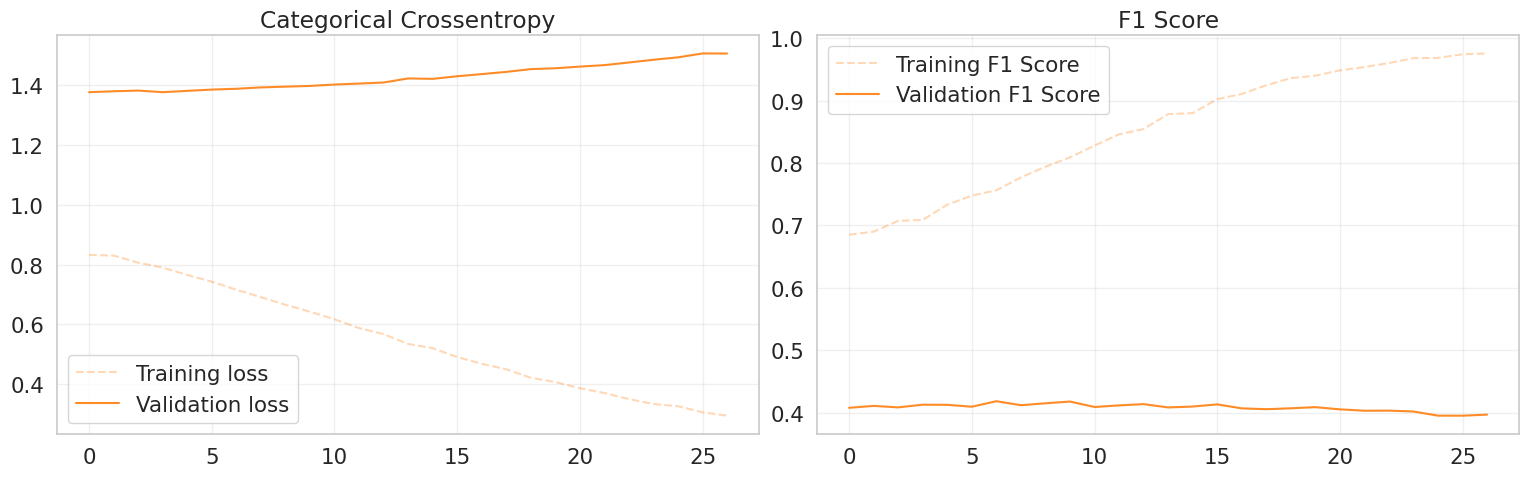

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(ft_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation F1 Score on the second axis (corrected from Accuracy)
ax2.plot(ft_history['train_f1'], label='Training F1 Score', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(ft_history['val_f1'], label='Validation F1 Score', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score') # Corrected title
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.4194
Precision over the validation set: 0.4190
Recall over the validation set: 0.4194
F1 score over the validation set: 0.4181


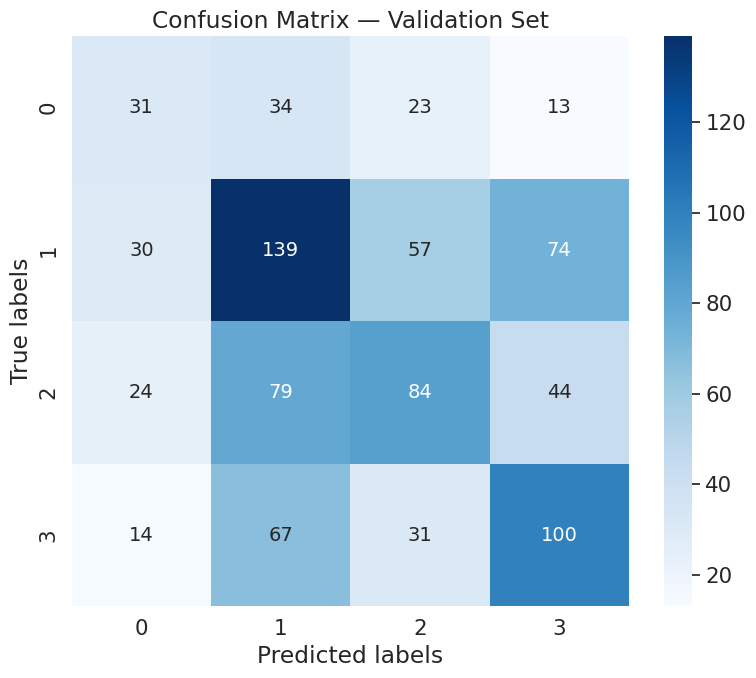

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    ft_model.eval() # Set model to evaluation mode
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = ft_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## SAVE MODEL

In [ ]:
from datetime import datetime
model=ft_model
# Directory dove salvare
save_dir = 'saved_models/'
os.makedirs(save_dir, exist_ok=True)

# Esempio dati
model_id = experiment_name #RIEMPIRE QUI CON TIPO DI MODELLO

# Salva il modello
model_path = os.path.join(save_dir, f'model_{model_id}_f1_{final_val_f1:.2f}.pth')
torch.save(model.state_dict(), model_path)

# Aggiorna CSV delle metriche
metrics_file = os.path.join(save_dir, f'{NET_TYPE}metrics.csv')
if os.path.exists(metrics_file):
    df_metrics = pd.read_csv(metrics_file)
else:
    df_metrics = pd.DataFrame(columns=['model_id','val_acc','val_prec','val_rec','val_f1', 'timestamp', 'path'])

df_metrics = pd.concat([df_metrics, pd.DataFrame([{
    'model_id': model_id,
    'val_f1' : final_val_f1,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'path': model_path
}])], ignore_index=True)

df_metrics.to_csv(metrics_file, index=False)

if os.path.exists(model_path):
    print(f"✅ Modello salvato correttamente in: {model_path}")
else:
    print("❌ Errore: il modello non è stato salvato")


✅ Modello salvato correttamente in: saved_models/model_ft_ResNet50(224,168,0.025,50)_unfreeze2_L10_L20_f1_41.81.pth
